# Exercise 2.5

Design and conduct an experiment to demonstrate the diculties that sample-average methods have for nonstationary problems. 

Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha$ = 0.1. Use $\epsilon$ = 0.1 and longer runs, say of 10,000 steps.

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform
from tqdm import tqdm
from time import perf_counter

## Normal Looping Solution

First pass takes about 1 min for 1000 runs

In [186]:
# step one: intialise the experiment -> starting q*
k = 10
epsilon = 0.1
alpha = 0.1
random_walk_std = 0.01

# fmt: off
def run_experiment(run_length: int):
    q_star = np.zeros(k)
    Q_sample_avg = np.zeros(k)
    Q_exp_avg = np.zeros(k)
    N_sample_avg = np.zeros(k)
    sample_avg_rewards = np.zeros(run_length)
    exp_avg_rewards = np.zeros(run_length)

    for i in range(run_length):
        # slightly update q_star via random walk
        random_walk = np.random.normal(0, random_walk_std, size=k)
        q_star += random_walk

        # 90% of the time take the greedy option, otherwise take a random action
        p = uniform(low=0, high=1)
        if p >= epsilon:
            A_sample_avg = np.argmax(Q_sample_avg)
            A_exp_avg = np.argmax(Q_exp_avg)
        else:
            A_sample_avg = A_exp_avg = np.random.choice(k)

        # update Q: Sample-Average
        R_sample_avg = q_star[A_sample_avg]
        N_sample_avg[A_sample_avg] += 1
        Q_sample_avg[A_sample_avg] += (1 / N_sample_avg[A_sample_avg]) * (R_sample_avg - Q_sample_avg[A_sample_avg])

        # Update Q: Exponential Recency-Weighted Average
        R_exp_avg = q_star[A_exp_avg]
        Q_exp_avg[A_exp_avg] += alpha * (R_exp_avg - Q_exp_avg[A_exp_avg])

        # update the reward trackers for plotting
        sample_avg_rewards[i] = R_sample_avg
        exp_avg_rewards[i] = R_exp_avg

    return sample_avg_rewards, exp_avg_rewards

In [187]:
num_runs = 1_000
run_length = 10_000

start_looped = perf_counter()
sample_avg_rewards = np.zeros((num_runs, run_length))
exp_avg_rewards = np.zeros((num_runs, run_length))
for i in tqdm(range(num_runs)):
    sample_avg_vals, exp_avg_vals = run_experiment(run_length)
    sample_avg_rewards[i] = sample_avg_vals
    exp_avg_rewards[i] = exp_avg_vals

end_looped = perf_counter()

100%|██████████| 1000/1000 [00:49<00:00, 20.20it/s]


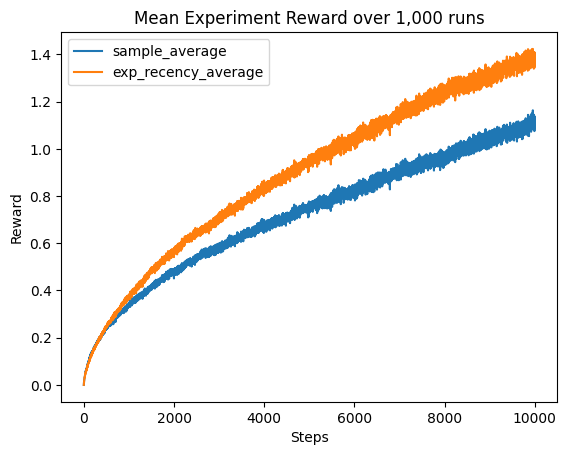

In [188]:
sample_avg_plot = sample_avg_rewards.mean(axis=0)
exp_avg_plot = exp_avg_rewards.mean(axis=0)

# sample_avg_plot_smoothed = sample_avg_plot.reshape(250, -1).mean(axis=1)
# exp_avg_plot_smoothed = exp_avg_plot.reshape(250, -1).mean(axis=1)

plt.plot(sample_avg_plot, label="sample_average")
plt.plot(exp_avg_plot, label="exp_recency_average")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title(f"Mean Experiment Reward over {num_runs:,} runs")
plt.legend()
plt.show()

## Batched Solution
Takes ~30 seconds for 10,000 runs ~16x speedup. The main awkwardness was writing the appropriate locator - I suspect this is why people use the first dimension for batches

In [189]:
start_batched = perf_counter()

batch_size = 10_000
run_length = 10_000
q_star = np.zeros((k, batch_size))
Q_sample_avg = np.zeros((k, batch_size))
Q_exp_avg = np.zeros((k, batch_size))
N_sample_avg = np.zeros((k, batch_size))
sample_avg_rewards = np.zeros((run_length, batch_size))
exp_avg_rewards = np.zeros((run_length, batch_size))

for i in range(run_length):
    # slightly update q_star via random walk
    random_walk = np.random.normal(0, random_walk_std, size=(k, batch_size))  # 10x50
    q_star += random_walk

    # 90% of the time take the greedy option, otherwise take a random action
    p = uniform(low=0, high=1, size=batch_size)
    epsilon_mask = (p > epsilon).astype(int)

    non_greedy_choice = np.random.choice(k, size=batch_size)
    A_sample_avg = (
        epsilon_mask * np.argmax(Q_sample_avg, axis=0)
        + (1 - epsilon_mask) * non_greedy_choice
    )
    A_exp_avg = (
        epsilon_mask * np.argmax(Q_exp_avg, axis=0)
        + (1 - epsilon_mask) * non_greedy_choice
    )

    # update Q: Sample-Average
    locator = A_sample_avg, np.arange(
        A_sample_avg.shape[0]
    )  # iterates over each batch and selects the appropriate index
    R_sample_avg = q_star[locator]
    N_sample_avg[locator] += 1
    Q_sample_avg[locator] += (1 / N_sample_avg[locator]) * (
        R_sample_avg - Q_sample_avg[locator]
    )

    # Update Q: Exponential Recency-Weighted Average
    locator = A_exp_avg, np.arange(A_exp_avg.shape[0])
    R_exp_avg = q_star[locator]
    Q_exp_avg[locator] += alpha * (R_exp_avg - Q_exp_avg[locator])

    # update the reward trackers for plotting
    sample_avg_rewards[i] = R_sample_avg
    exp_avg_rewards[i] = R_exp_avg

end_batched = perf_counter()

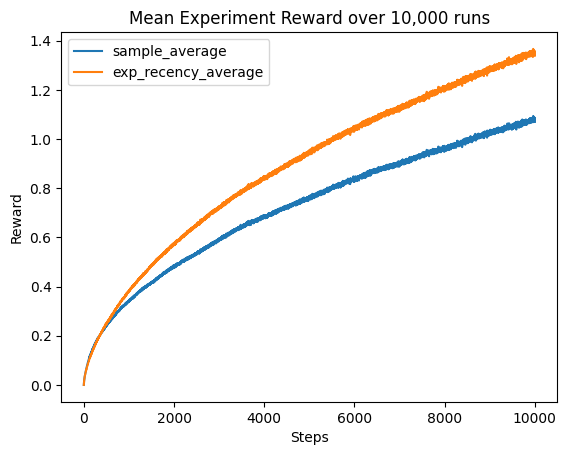

In [190]:
plt.plot(sample_avg_rewards.mean(axis=1), label="sample_average")
plt.plot(exp_avg_rewards.mean(axis=1), label="exp_recency_average")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title(f"Mean Experiment Reward over {batch_size:,} runs")
plt.legend()
plt.show()
plt.show()

In [192]:
time_looped = end_looped - start_looped
time_batched = end_batched - start_looped

perf_increase = (time_batched * batch_size) / (time_looped * num_runs)
print(f"Total {perf_increase:.1f}x speedup!!")

Total 15.6x speedup!!
